In [15]:
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80	# estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax1, bars, color):
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/100.0, yval, f'{yval:.2f}', va='bottom', color=color)

# Read the file and extract the data
file_path = './logs/levelbeats.csv'
data = pd.read_csv(file_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

# Remove outliers from data, although keep in mind they do represent massive amounts of exploration at the beginning of training
dropped = 0
indexes = [index for index, win_time in enumerate(data['completion_timesteps']) if win_time > 150000]
for index in indexes:
    data = data.drop(index)
    dropped += 1

# Find the split in the .csv between Pass 1 and Pass 2
with open(file_path, 'r') as file:
    lines = file.readlines()
split_index = lines.index('\n')
print("split_index:", split_index)

# Split the data corresponding to Pass 1 and Pass 2, find averages & 5 fastests
cutoff = 50
pass1_timesteps = data['completion_timesteps'][:split_index]
pass2_timesteps = data['completion_timesteps'][split_index:]
average_pass1 = convert_to_time(pass1_timesteps[-cutoff:].mean())
average_pass2 = convert_to_time(pass2_timesteps[-cutoff:].mean())
fastest_pass1 = data[:split_index].nsmallest(5, 'completion_timesteps')
fastest_pass2 = data[split_index:].nsmallest(5, 'completion_timesteps')

# Print out the data about the averages
print(f"Pass 1 average completion time: {convert_to_time(pass1_timesteps.mean())} seconds")
print(f"Pass 2 average completion time: {convert_to_time(pass2_timesteps.mean())} seconds")
print(f"Pass 1 average completion time for last {cutoff} wins: {average_pass1} seconds")
print(f"Pass 2 average completion time for last {cutoff} wins: {average_pass2} seconds")

split_index: 296
Pass 1 average completion time: 123.74 seconds
Pass 2 average completion time: 66.38 seconds
Pass 1 average completion time for last 50 wins: 91.25 seconds
Pass 2 average completion time for last 50 wins: 45.43 seconds


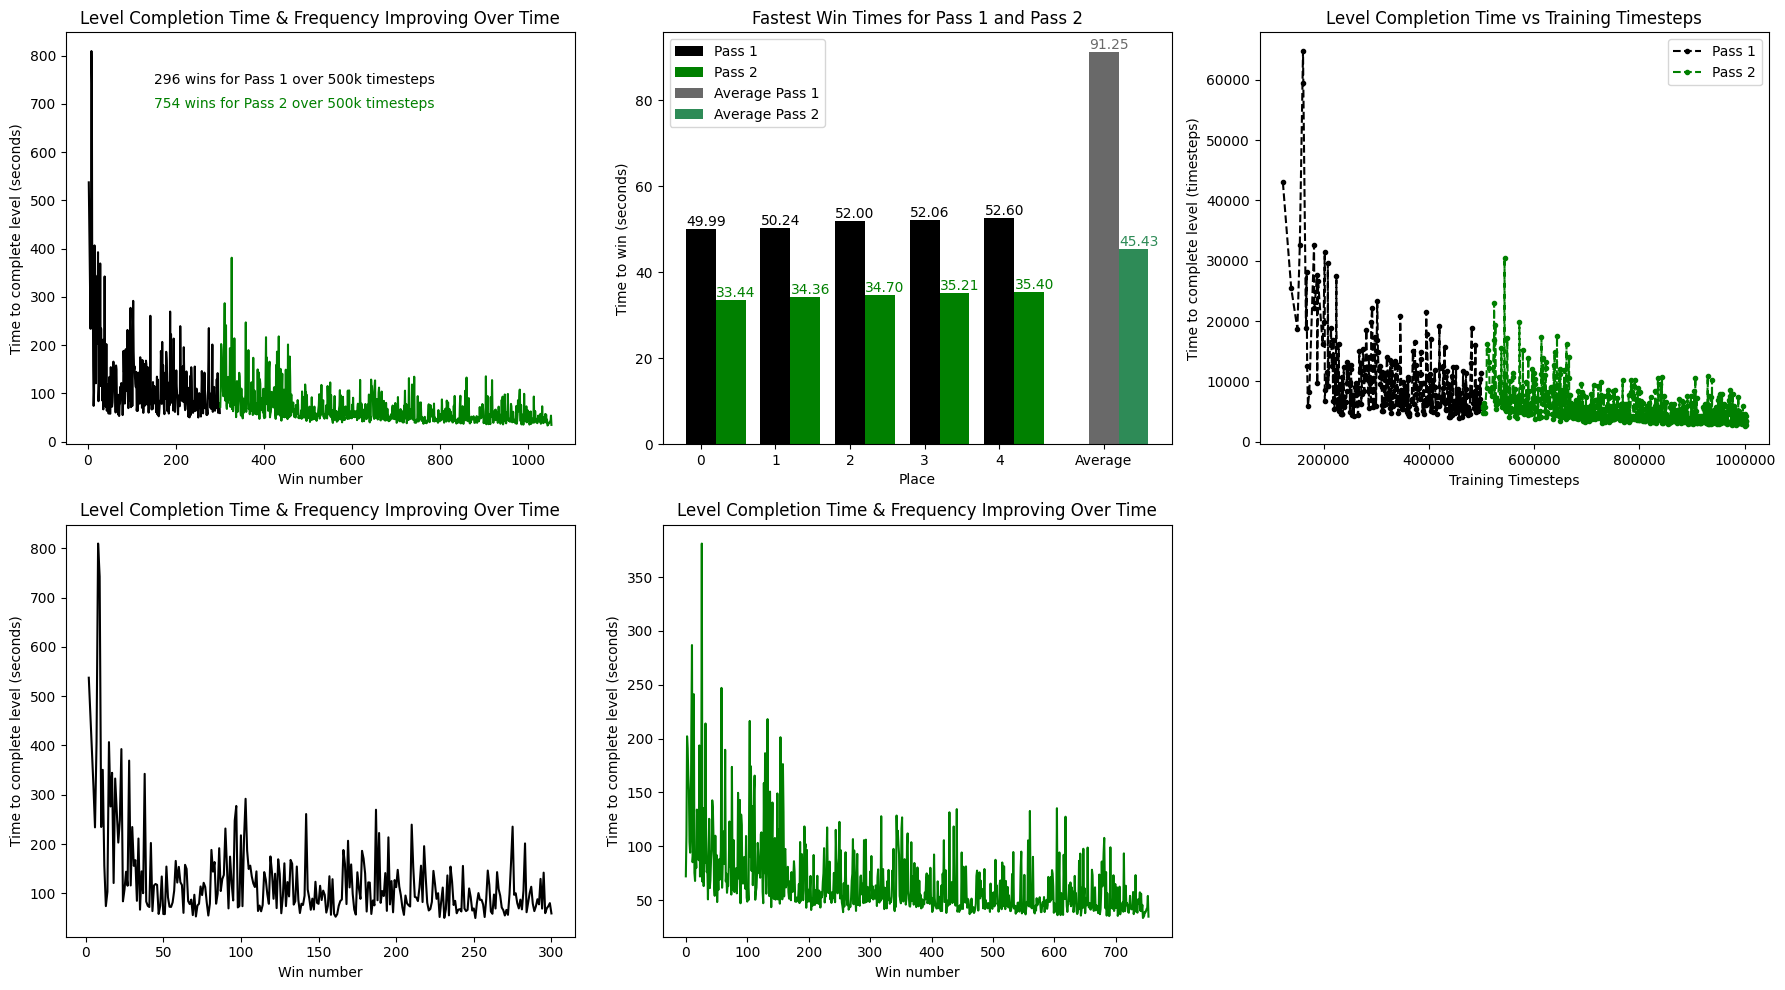

In [16]:
# Graph setup
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])

# Graph level completion time and frequency improving over time
ax0.plot(convert_to_time(pass1_timesteps), color='black')
ax0.plot(convert_to_time(pass2_timesteps), color='green')
ax0.set_title('Level Completion Time & Frequency Improving Over Time')
ax0.set_ylabel('Time to complete level (seconds)')
ax0.set_xlabel('Win number')
ax0.text(150, 750, f'{len(pass1_timesteps)} wins for Pass 1 over 500k timesteps', color='black', verticalalignment='center', horizontalalignment='left')
ax0.text(150, 700, f'{len(pass2_timesteps)} wins for Pass 2 over 500k timesteps', color='green', verticalalignment='center', horizontalalignment='left')

width = 0.4
indices_pass1 = range(len(fastest_pass1))
indices_pass2 = [index + width for index in indices_pass1]
bars1 =     ax1.bar(indices_pass1,                      convert_to_time(fastest_pass1['completion_timesteps']), width=width, label='Pass 1', color='black')
bars2 =     ax1.bar(indices_pass2,                      convert_to_time(fastest_pass2['completion_timesteps']), width=width, label='Pass 2', color='green')
bars1_avg = ax1.bar([max(indices_pass2) + 1],           [average_pass1],                                        width=width, label='Average Pass 1', color='dimgray')
bars2_avg = ax1.bar([max(indices_pass2) + 1 + width],   [average_pass2],                                        width=width, label='Average Pass 2', color='seagreen')

label_bars(ax1, bars1, 'black')
label_bars(ax1, bars2, 'green')
label_bars(ax1, bars1_avg, 'dimgray')
label_bars(ax1, bars2_avg, 'seagreen')

ax1.set_xticks(list(indices_pass1) + [max(indices_pass2) + 1])      # Set x-ticks to indices and "Average" position
ax1.set_xticklabels(list(range(len(fastest_pass1))) + ['Average'])  # Set x-tick labels to index numbers and "Average"
ax1.set_title('Fastest Win Times for Pass 1 and Pass 2')
ax1.set_ylabel('Time to win (seconds)')
ax1.set_xlabel('Place')
ax1.legend()

ax2.plot(data['training_timesteps'][:split_index - dropped], data['completion_timesteps'][:split_index - dropped], linestyle='--', marker='.', color='black', label='Pass 1')
ax2.plot(data['training_timesteps'][split_index - dropped:] + 500000, data['completion_timesteps'][split_index - dropped:], linestyle='--', marker='.', color='green', label='Pass 2')
ax2.set_title('Level Completion Time vs Training Timesteps')
ax2.set_xlabel('Training Timesteps')
ax2.set_ylabel('Time to complete level (timesteps)')
ax2.legend(loc='upper right')
ax2.get_xaxis().get_major_formatter().set_scientific(False)

ax3.plot(convert_to_time(pass1_timesteps), color='black')
ax3.set_title('Level Completion Time & Frequency Improving Over Time')
ax3.set_ylabel('Time to complete level (seconds)')
ax3.set_xlabel('Win number')

x_values = range(len(convert_to_time(pass2_timesteps)))
ax4.plot([x for x in x_values], convert_to_time(pass2_timesteps), color='green')
ax4.set_title('Level Completion Time & Frequency Improving Over Time')
ax4.set_ylabel('Time to complete level (seconds)')
ax4.set_xlabel('Win number')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()